In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data

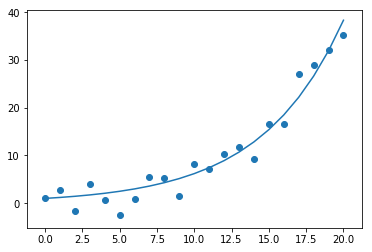

In [17]:
np.random.seed(4)
xin = 1
a = 1.2
var = 10
yout = [xin + np.random.normal(0,np.sqrt(var))]
xout = [xin]
for i in range(20):
    xout.append(xin*a)
    xin = xout[-1]
    yout.append(xout[-1] + np.random.normal(0,np.sqrt(var)))
plt.plot(range(21),xout)
plt.scatter(range(21),yout)

In [ ]:
def model(mu_a, mu_x, sig_x):
    mu_x = mu_a*mu_x
    y =mu_x + np.random.normal(0,sig_x)
    return mu_x, y

In [ ]:
def ll_gaussian(y, mu, log_var):
    sigma = np.exp(0.5 * log_var)
    return -0.5 * np.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, 1)
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [ ]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var